In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, make_scorer, precision_score, recall_score, fbeta_score, matthews_corrcoef, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# --- 1. Loading the dataset ---
def load_dataset(file_path):
    """
    Loads a dataset from a specified file path.
    Assumes CSV format for simplicity.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully from {file_path}. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading the dataset: {e}")
        return None

In [ ]:
# --- 2. Perform EDA ---
def perform_eda(df, target_column):
    """
    Performs Exploratory Data Analysis including:
    a. Handling missing values
    b. Performing categorical encoding
    c. Performing outlier removal (using IQR)
    d. Standardizing/normalizing numerical features
    """
    print("\n--- Starting EDA ---")

    df_eda = df.copy()

    # Separate features and target
    X = df_eda.drop(columns=[target_column])
    y = df_eda[target_column]

    # Identify numerical and categorical features
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='object').columns.tolist()

    print(f"Numerical features: {numerical_features}")
    print(f"Categorical features: {categorical_features}")

    # a. Handle Missing Values
    print("\n--- Handling Missing Values ---")
    numerical_imputer = SimpleImputer(strategy='mean') # or 'median'
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    for col in numerical_features:
        if df_eda[col].isnull().sum() > 0:
            print(f"Imputing missing values in numerical column: {col}")
            df_eda[col] = numerical_imputer.fit_transform(df_eda[[col]])

    for col in categorical_features:
        if df_eda[col].isnull().sum() > 0:
            print(f"Imputing missing values in categorical column: {col}")
            df_eda[col] = categorical_imputer.fit_transform(df_eda[[col]])
    print("Missing value imputation complete.")


    # b. Perform Categorical Encoding (One-Hot Encoding)
    print("\n--- Performing Categorical Encoding ---")
    if categorical_features:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df_eda[categorical_features])
        encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features), index=df_eda.index)
        df_eda = pd.concat([df_eda.drop(columns=categorical_features), encoded_df], axis=1)
        print("Categorical encoding complete using OneHotEncoder.")
    else:
        print("No categorical features found for encoding.")


    '''# c. Perform Outlier Removal (using IQR method)
    print("\n--- Performing Outlier Removal (IQR method) ---")
    original_shape = df_eda.shape[0]
    for col in numerical_features:
        Q1 = df_eda[col].quantile(0.25)
        Q3 = df_eda[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_eda = df_eda[(df_eda[col] >= lower_bound) & (df_eda[col] <= upper_bound)]
    new_shape = df_eda.shape[0]
    print(f"Outlier removal complete. Removed {original_shape - new_shape} rows.")'''


    # d. Standardize/Normalize numerical features
    print("\n--- Standardizing Numerical Features ---")
    # Re-identify numerical features after encoding (new encoded columns are numerical)
    numerical_features_after_encoding = df_eda.select_dtypes(include=np.number).columns.tolist()
    # Exclude the target column if it's numerical and we haven't dropped it yet
    if target_column in numerical_features_after_encoding:
        numerical_features_after_encoding.remove(target_column)

    scaler = StandardScaler() # Or MinMaxScaler()
    df_eda[numerical_features_after_encoding] = scaler.fit_transform(df_eda[numerical_features_after_encoding])
    print("Numerical features standardized using StandardScaler.")

    '''# d. Normalize numerical features
    print("\n--- Normalizing Numerical Features ---")
    # Re-identify numerical features after encoding (new encoded columns are numerical)
    numerical_features_after_encoding = df_eda.select_dtypes(include=np.number).columns.tolist()
    # Exclude the target column if it's numerical and we haven't dropped it yet
    if target_column in numerical_features_after_encoding:
        numerical_features_after_encoding.remove(target_column)

    scaler = MinMaxScaler()  # Normalization scales data to [0, 1] range
    df_eda[numerical_features_after_encoding] = scaler.fit_transform(df_eda[numerical_features_after_encoding])
    print("Numerical features normalized using MinMaxScaler.")'''


    print("\n--- EDA Complete ---")
    return df_eda, target_column # Return the processed DataFrame and target column name


In [ ]:
# --- 3. Splitting the dataset ---
def split_dataset(df, target_column, test_size=0.2, random_state=42):
    """
    Splits the dataset into training and testing sets.
    """
    print("\n--- Splitting Dataset ---")
    X = df.drop(columns=[target_column])


    y = df[target_column]
    print(y.value_counts())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    print(f"Dataset split: X_train shape {X_train.shape}, X_test shape {X_test.shape}")
    print(f"y_train shape {y_train.shape}, y_test shape {y_test.shape}")
    return X_train, X_test, y_train, y_test

In [ ]:
# --- 4. Model Defining ---
def define_model(model_type='LogisticRegression',k=1):
    """
    Defines and returns a machine learning model.
    Can be extended to include other models.
    """
    print("\n--- Defining Model ---")
    if model_type == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(random_state=42, solver='liblinear')
    elif model_type=='DecisionTreeClassifier':
        from sklearn.tree import DecisionTreeClassifier
        model = DecisionTreeClassifier(criterion="gini",random_state=100)
    elif model_type=='AdaBoostClassifier':
      from sklearn.ensemble import AdaBoostClassifier
      model = AdaBoostClassifier(n_estimators=50,random_state=42)
    elif model_type=='GradientBoostingClassifier':
      from sklearn.ensemble import GradientBoostingClassifier
      model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
    elif model_type=='XGBClassifier':
        from xgboost import XGBClassifier
        model = XGBClassifier(random_state=42)
    elif model_type=='GaussianNB':
        from sklearn.naive_bayes import GaussianNB
        model = GaussianNB()
    elif model_type=='BernoulliNB':
        from sklearn.naive_bayes import BernoulliNB
        model = BernoulliNB()
    elif model_type=='MultinomialNB':
        from sklearn.naive_bayes import MultinomialNB
        model = MultinomialNB()
    elif model_type=='KNN':
        from sklearn.neighbors import KNeighborsClassifier
        model = KNeighborsClassifier(n_neighbors=k)
    elif model_type=='KNN_BallTree':
        from sklearn.neighbors import KNeighborsClassifier
        model = KNeighborsClassifier(n_neighbors=k,algorithm='ball_tree')
    elif model_type=='KNN_KDTree':
        from sklearn.neighbors import KNeighborsClassifier
        model = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    elif model_type == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(random_state=42)
    elif model_type == 'SVC':
        from sklearn.svm import SVC
        model = SVC(random_state=42, probability=True) # probability=True for ROC curve
    elif model_type == 'Stacked1':
        from sklearn.ensemble import StackingClassifier
        from sklearn.linear_model import LogisticRegression
        from sklearn.svm import SVC
        from sklearn.naive_bayes import GaussianNB
        from sklearn.tree import DecisionTreeClassifier
        base_learners = [
            ('svm', SVC(probability=True, kernel='linear')),  # SVM needs probability=True for stacking
            ('nb', GaussianNB()),                             # Naïve Bayes
            ('dt', DecisionTreeClassifier(random_state=42))   # Decision Tree
        ]

        # 4. Define meta-learner (level-1 model)
        meta_learner = LogisticRegression()

        # 5. Create stacking classifier
        model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
    elif model_type == 'Stacked2':
          from sklearn.ensemble import StackingClassifier
          from sklearn.linear_model import LogisticRegression
          from sklearn.svm import SVC
          from sklearn.naive_bayes import GaussianNB
          from sklearn.tree import DecisionTreeClassifier
          from sklearn.neighbors import KNeighborsClassifier
          base_learners = [
              ('svm', SVC(probability=True, kernel='rbf')),   # SVM with probability=True
              ('dt', DecisionTreeClassifier(random_state=42)), # Decision Tree
              ('knn', KNeighborsClassifier(n_neighbors=5))     # KNN
          ]

          # 4. Define meta-learner (level-1 model)
          meta_learner = LogisticRegression()

          # 5. Create stacking classifier
          model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
    elif model_type == 'Stacked3':
          from sklearn.ensemble import StackingClassifier
          from sklearn.linear_model import LogisticRegression
          from sklearn.svm import SVC
          from sklearn.naive_bayes import GaussianNB
          from sklearn.tree import DecisionTreeClassifier
          base_learners = [
              ('svm', SVC(probability=True, kernel='linear')),  # SVM needs probability=True for stacking
              ('nb', GaussianNB()),                             # Naïve Bayes
              ('dt', DecisionTreeClassifier(random_state=42))   # Decision Tree
          ]

          # 4. Define meta-learner (level-1 model)
          from sklearn.ensemble import RandomForestClassifier
          meta_learner = RandomForestClassifier()

          # 5. Create stacking classifier
          model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

    else:
        raise ValueError(f"Model type '{model_type}' not supported. Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'.")
    print(f"Model defined: {model_type}")
    return model

In [ ]:
def performance_analysis(model, X_train, y_train, X_test, y_test, param_grid):
    """
    Performs model training and comprehensive performance analysis including:
    a. Confusion Matrix
    b. ROC curve
    c. Cross-validation for Accuracy, Precision, Recall, F-Beta score, MCC
       Prints cross-validation results as a table for all 5 folds.
    """
    print("\n--- Performing Performance Analysis ---")
    import time
    start_kd = time.time()

    #------------------------------------------------------
    if param_grid is not None:
      from sklearn.model_selection import GridSearchCV
      grid = GridSearchCV(
          estimator=model,
          param_grid=param_grid,
          cv=5,
          scoring="accuracy",
          n_jobs=-1
      )

      grid.fit(X_train, y_train)

      # -------------------
      # Results
      # -------------------
      print("GRID SEARCH RESULTS")
      print("Best parameters from Grid Search:", grid.best_params_)
      print("Best cross-validation score:", grid.best_score_)
       # Evaluate on test set
      y_pred = grid.predict(X_test)
      print("Test accuracy using Grid Search:", accuracy_score(y_test, y_pred))
      best_model = grid.best_estimator_

      #------------------------------------------------------
      # Probabilities for ROC
      y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None
    else:
      grid=model
      grid.fit(X_train, y_train)
      y_pred = grid.predict(X_test)
      best_model = grid
      y_proba = None
    end_kd = time.time()
    print(f"Training time: {end_kd - start_kd:.6f} seconds")



    # a. Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # b. ROC Curve
    print("\n--- ROC Curve ---")
    if y_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        print("Model does not support probability outputs. Skipping ROC curve.")

    #------------------------------------------------------
    # Cross-validation for multiple metrics in one pass
    print("\n--- Cross-Validation (5-Fold) ---")
    from sklearn.model_selection import cross_validate

    scoring_metrics = {
        'Accuracy': 'accuracy',
        'Precision': make_scorer(precision_score, average='binary', zero_division=0),
        'Recall': make_scorer(recall_score, average='binary', zero_division=0),
        'F1': make_scorer(fbeta_score, beta=1, average='binary', zero_division=0),
        'MCC': make_scorer(matthews_corrcoef)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    X_combined = pd.concat([X_train, X_test])
    y_combined = pd.concat([y_train, y_test])

    cv_results = cross_validate(best_model, X_combined, y_combined, cv=cv, scoring=scoring_metrics)

    # Convert results into a table
    cv_df = pd.DataFrame({
        "Accuracy": cv_results['test_Accuracy'],
        "Precision": cv_results['test_Precision'],
        "Recall": cv_results['test_Recall'],
        "F1": cv_results['test_F1'],
        "MCC": cv_results['test_MCC']
    })
    cv_df.loc["Mean"] = cv_df.mean()
    cv_df.loc["Std"] = cv_df.std()

    print("\n--- Cross-Validation Results (5 Folds) ---")
    print(cv_df.round(4).to_string())

    print("\n--- Performance Analysis Complete ---")
    plot_feature_importance(grid, X_train, y_train, X_train.columns, "Decision Tree Feature Importance")
    return cv_df


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.inspection import permutation_importance

def plot_feature_importance(model, X, y, feature_names, title="Feature Importance"):
    """
    Plots feature importance for tree-based and linear models.
    Falls back to permutation importance if no direct attribute is available.
    """
    importance = None

    # Case 1: Tree-based models
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_

    # Case 2: Linear models (coef_)
    elif hasattr(model, "coef_"):
        importance = np.abs(model.coef_[0])

    # Case 3: Others -> use permutation importance
    else:
        print("⚠️ Using permutation importance (slower).")
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
        importance = result.importances_mean

    # Sort features by importance
    indices = np.argsort(importance)[::-1]
    sorted_features = [feature_names[i] for i in indices]
    sorted_importance = importance[indices]

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_importance, y=sorted_features, palette="viridis")
    plt.title(title, fontsize=14)
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


Dataset loaded successfully from breast_cancer_wisconsin_diagnostic.csv. Shape: (569, 31)
Target column 'Diagnosis' converted to numerical using LabelEncoder.

--- Starting EDA ---
Numerical features: ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
Categorical features: []

--- Handling Missing Values ---
Missing value imputation complete.

--- Performing Categorical Encoding ---
No categorical features found for encoding.

--- Standardizing Numerical Features ---
Numerical features standardized using StandardScaler.

--- EDA Complete ---

--- Splitting Dataset ---
Diagnosis
0    357
1    212
Name: count,

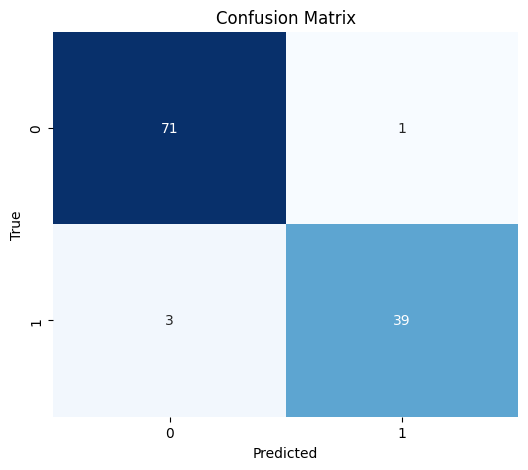


--- ROC Curve ---


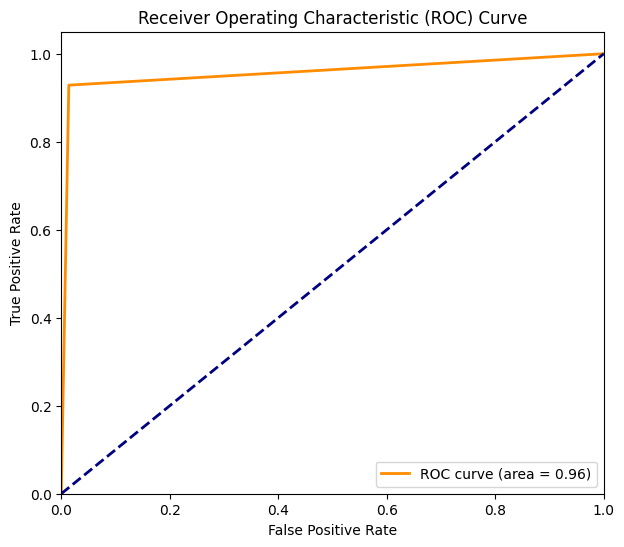

ROC AUC: 0.9573

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
      Accuracy  Precision  Recall      F1     MCC
0       0.9386     0.9091  0.9302  0.9195  0.8701
1       0.9211     0.9250  0.8605  0.8916  0.8310
2       0.9211     0.8837  0.9048  0.8941  0.8313
3       0.9474     0.9286  0.9286  0.9286  0.8869
4       0.8850     0.8222  0.8810  0.8506  0.7584
Mean    0.9226     0.8937  0.9010  0.8969  0.8355
Std     0.0214     0.0391  0.0271  0.0272  0.0443

--- Performance Analysis Complete ---
⚠️ Using permutation importance (slower).


/tmp/ipython-input-1444998124.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance, y=sorted_features, palette="viridis")


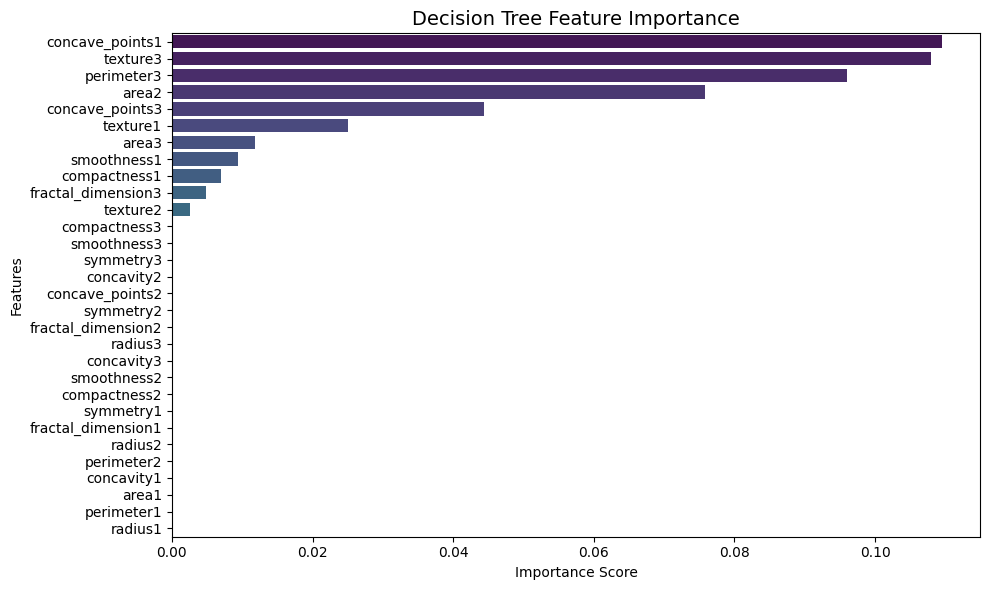

Accuracy: 0.923
Precision: 0.894
Recall: 0.901
F1 Score: 0.897
Mcc: 0.836


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'breast_cancer_wisconsin_diagnostic.csv' # Replace with your dataset path
    TARGET_COLUMN = 'Diagnosis' # Replace with your target column name
    MODEL_TYPE = 'DecisionTreeClassifier' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'
    param_grid= {
    "criterion": ["gini", "entropy", "log_loss"],  # splitting criteria
    "max_depth": [None, 3, 5, 10, 20],             # depth of tree
    "min_samples_split": [2, 5, 10],               # min samples to split
    "min_samples_leaf": [1, 2, 4],                 # min samples per leaf
    "max_features": [None, "sqrt", "log2"]         # feature selection
}


    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        dt_model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(dt_model, X_train, y_train, X_test, y_test,param_grid)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("F1 Score:",round(cv_results_table.loc['Mean','F1'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','MCC'],3))




Dataset loaded successfully from breast_cancer_wisconsin_diagnostic.csv. Shape: (569, 31)
Target column 'Diagnosis' converted to numerical using LabelEncoder.

--- Starting EDA ---
Numerical features: ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
Categorical features: []

--- Handling Missing Values ---
Missing value imputation complete.

--- Performing Categorical Encoding ---
No categorical features found for encoding.

--- Standardizing Numerical Features ---
Numerical features standardized using StandardScaler.

--- EDA Complete ---

--- Splitting Dataset ---
Diagnosis
0    357
1    212
Name: count,

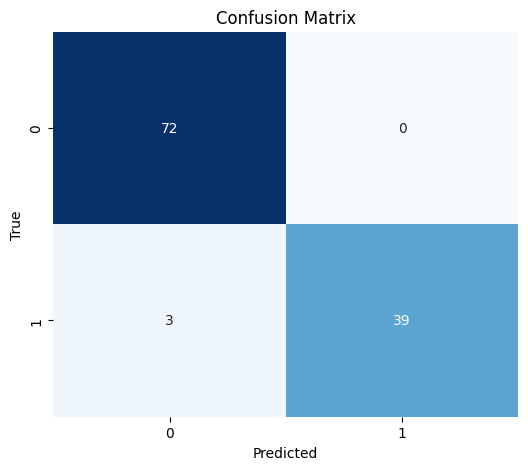


--- ROC Curve ---


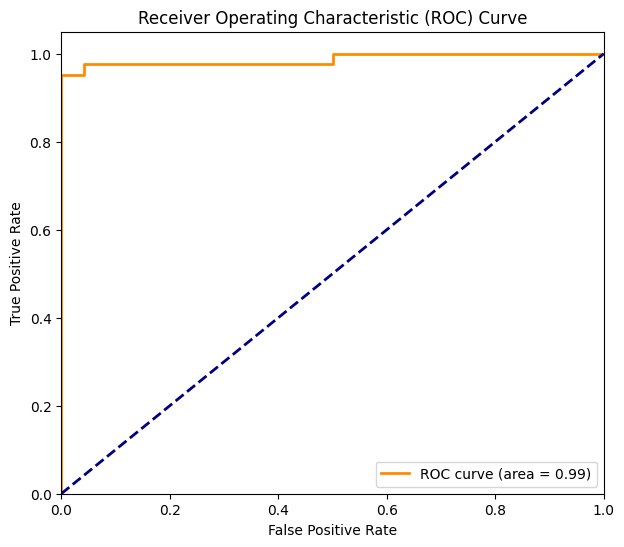

ROC AUC: 0.9871

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
      Accuracy  Precision  Recall      F1     MCC
0       0.9737     1.0000  0.9302  0.9639  0.9447
1       0.9737     0.9762  0.9535  0.9647  0.9439
2       0.9649     0.9750  0.9286  0.9512  0.9245
3       0.9825     0.9762  0.9762  0.9762  0.9623
4       0.9469     0.9500  0.9048  0.9268  0.8859
Mean    0.9683     0.9755  0.9386  0.9566  0.9323
Std     0.0121     0.0158  0.0243  0.0168  0.0261

--- Performance Analysis Complete ---
Accuracy: 0.968
Precision: 0.975
Recall: 0.939
F1 Score: 0.957
Mcc: 0.932


In [ ]:
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'breast_cancer_wisconsin_diagnostic.csv' # Replace with your dataset path
    TARGET_COLUMN = 'Diagnosis' # Replace with your target column name
    MODEL_TYPE = 'AdaBoostClassifier' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'
    from sklearn.tree import DecisionTreeClassifier
    param_grid = {
    "n_estimators": [50, 100, 200],  # number of weak learners
    "learning_rate": [0.001, 0.01, 0.1, 1],  # weight of each learner
    "estimator": [DecisionTreeClassifier(max_depth=1),
                  DecisionTreeClassifier(max_depth=2)]
}


    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test,param_grid)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("F1 Score:",round(cv_results_table.loc['Mean','F1'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','MCC'],3))

Dataset loaded successfully from breast_cancer_wisconsin_diagnostic.csv. Shape: (569, 31)
Target column 'Diagnosis' converted to numerical using LabelEncoder.

--- Starting EDA ---
Numerical features: ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
Categorical features: []

--- Handling Missing Values ---
Missing value imputation complete.

--- Performing Categorical Encoding ---
No categorical features found for encoding.

--- Standardizing Numerical Features ---
Numerical features standardized using StandardScaler.

--- EDA Complete ---

--- Splitting Dataset ---
Diagnosis
0    357
1    212
Name: count,

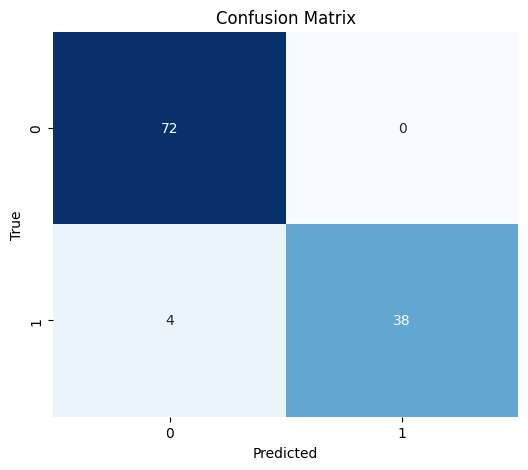


--- ROC Curve ---


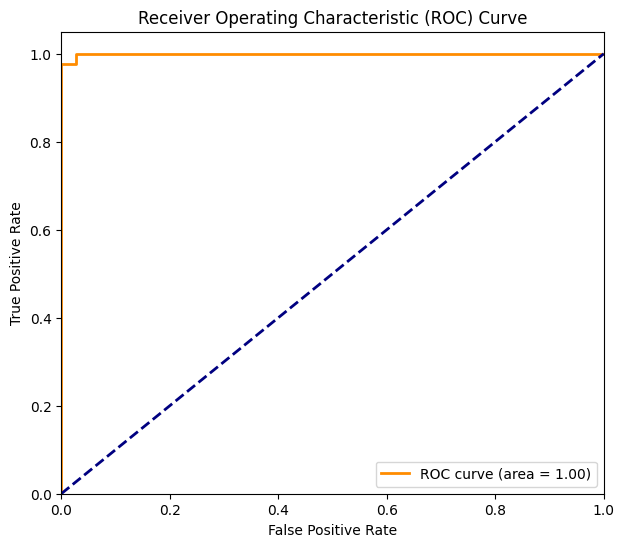

ROC AUC: 0.9993

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
      Accuracy  Precision  Recall      F1     MCC
0       0.9825     1.0000  0.9535  0.9762  0.9630
1       0.9912     1.0000  0.9767  0.9882  0.9814
2       0.9649     0.9524  0.9524  0.9524  0.9246
3       0.9825     1.0000  0.9524  0.9756  0.9626
4       0.9292     0.9048  0.9048  0.9048  0.8484
Mean    0.9701     0.9714  0.9480  0.9594  0.9360
Std     0.0221     0.0381  0.0235  0.0297  0.0475

--- Performance Analysis Complete ---
Accuracy: 0.97
Precision: 0.971
Recall: 0.948
Fbeta Score: 0.959
Mcc: 0.936


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'breast_cancer_wisconsin_diagnostic.csv' # Replace with your dataset path
    TARGET_COLUMN = 'Diagnosis' # Replace with your target column name
    MODEL_TYPE = 'GradientBoostingClassifier' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'
    param_grid = {
    "n_estimators": [100, 200],         # number of boosting stages
    "learning_rate": [0.01, 0.05, 0.1, 0.2], # step size
    "max_depth": [3, 5, 10],                 # depth of individual trees
    "min_samples_split": [2, 5, 10],         # min samples to split
    "min_samples_leaf": [1, 2, 4],           # min samples per leaf
    "subsample": [0.6, 0.8, 1.0],            # fraction of data used per tree
    "max_features": [None, "sqrt", "log2"]   # number of features considered
}
    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test,param_grid)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','F1'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','MCC'],3))

Dataset loaded successfully from breast_cancer_wisconsin_diagnostic.csv. Shape: (569, 31)
Target column 'Diagnosis' converted to numerical using LabelEncoder.

--- Starting EDA ---
Numerical features: ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
Categorical features: []

--- Handling Missing Values ---
Missing value imputation complete.

--- Performing Categorical Encoding ---
No categorical features found for encoding.

--- Standardizing Numerical Features ---
Numerical features standardized using StandardScaler.

--- EDA Complete ---

--- Splitting Dataset ---
Diagnosis
0    357
1    212
Name: count,

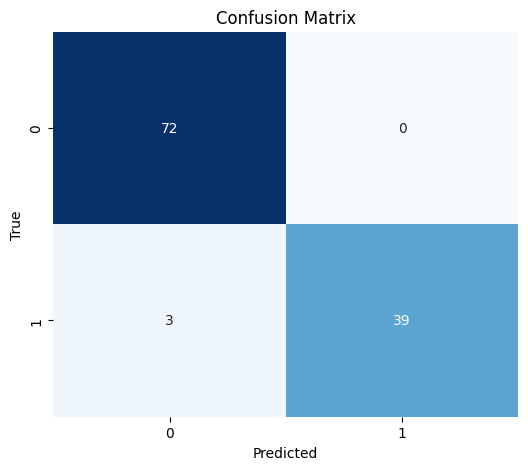


--- ROC Curve ---


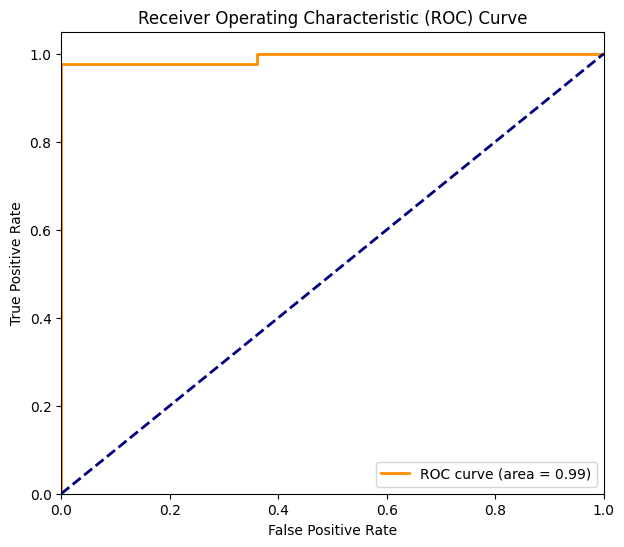

ROC AUC: 0.9914

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
      Accuracy  Precision  Recall      F1     MCC
0       0.9737     1.0000  0.9302  0.9639  0.9447
1       0.9825     0.9767  0.9767  0.9767  0.9627
2       0.9649     0.9750  0.9286  0.9512  0.9245
3       0.9737     0.9756  0.9524  0.9639  0.9433
4       0.9204     0.8667  0.9286  0.8966  0.8332
Mean    0.9630     0.9588  0.9433  0.9504  0.9217
Std     0.0220     0.0470  0.0190  0.0281  0.0458

--- Performance Analysis Complete ---
Accuracy: 0.963
Precision: 0.959
Recall: 0.943
Fbeta Score: 0.95
Mcc: 0.922


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'breast_cancer_wisconsin_diagnostic.csv' # Replace with your dataset path
    TARGET_COLUMN = 'Diagnosis' # Replace with your target column name
    MODEL_TYPE = 'XGBClassifier' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'
    param_grid= {
    "n_estimators": [100, 200],         # number of boosting rounds
    "learning_rate": [0.01, 0.05, 0.1, 0.2], # step size shrinkage
    "max_depth": [3, 5, 7, 10],              # tree depth
    "subsample": [0.6, 0.8, 1.0],            # fraction of training samples
    "colsample_bytree": [0.6, 0.8, 1.0],     # fraction of features per tree
    "gamma": [0, 0.1, 0.5, 1],               # min loss reduction to split
    "reg_lambda": [1, 5, 10],                # L2 regularization
    "reg_alpha": [0, 0.5, 1]                 # L1 regularization
}
    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test,param_grid)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','F1'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','MCC'],3))

Dataset loaded successfully from breast_cancer_wisconsin_diagnostic.csv. Shape: (569, 31)
Target column 'Diagnosis' converted to numerical using LabelEncoder.

--- Starting EDA ---
Numerical features: ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
Categorical features: []

--- Handling Missing Values ---
Missing value imputation complete.

--- Performing Categorical Encoding ---
No categorical features found for encoding.

--- Standardizing Numerical Features ---
Numerical features standardized using StandardScaler.

--- EDA Complete ---

--- Splitting Dataset ---
Diagnosis
0    357
1    212
Name: count,

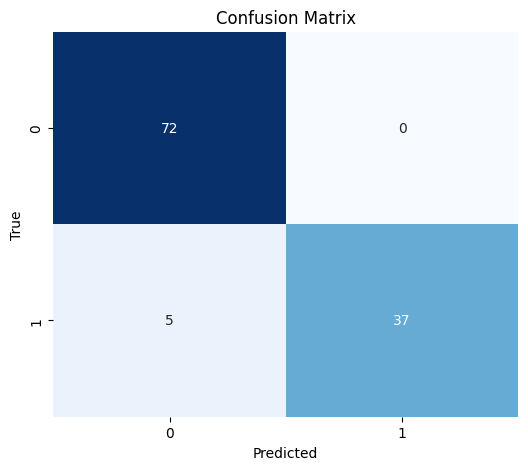


--- ROC Curve ---


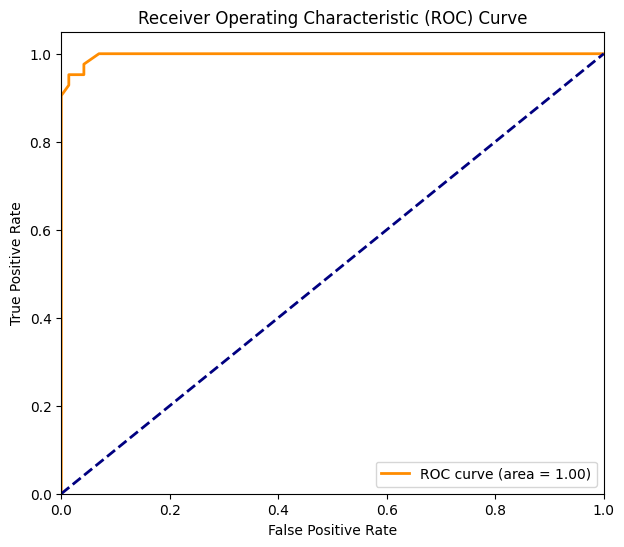

ROC AUC: 0.9972

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
      Accuracy  Precision  Recall      F1     MCC
0       0.9737     1.0000  0.9302  0.9639  0.9447
1       0.9825     0.9767  0.9767  0.9767  0.9627
2       0.9737     0.9756  0.9524  0.9639  0.9433
3       0.9825     1.0000  0.9524  0.9756  0.9626
4       0.9204     0.8837  0.9048  0.8941  0.8304
Mean    0.9665     0.9672  0.9433  0.9548  0.9288
Std     0.0234     0.0431  0.0242  0.0309  0.0499

--- Performance Analysis Complete ---
Accuracy: 0.967
Precision: 0.967
Recall: 0.943
Fbeta Score: 0.955
Mcc: 0.929


In [ ]:
   # --- Main execution flow ---
if __name__ == "__main__":
    # --- Configuration ---
    FILE_PATH = 'breast_cancer_wisconsin_diagnostic.csv' # Replace with your dataset path
    TARGET_COLUMN = 'Diagnosis' # Replace with your target column name
    MODEL_TYPE = 'RandomForestClassifier' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'
    param_grid = {
    "n_estimators": [25,50,100],         # number of trees
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]               # with/without replacement
}
    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test,param_grid)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','F1'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','MCC'],3))

Dataset loaded successfully from breast_cancer_wisconsin_diagnostic.csv. Shape: (569, 31)
Target column 'Diagnosis' converted to numerical using LabelEncoder.

--- Starting EDA ---
Numerical features: ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
Categorical features: []

--- Handling Missing Values ---
Missing value imputation complete.

--- Performing Categorical Encoding ---
No categorical features found for encoding.

--- Standardizing Numerical Features ---
Numerical features standardized using StandardScaler.

--- EDA Complete ---

--- Splitting Dataset ---
Diagnosis
0    357
1    212
Name: count,

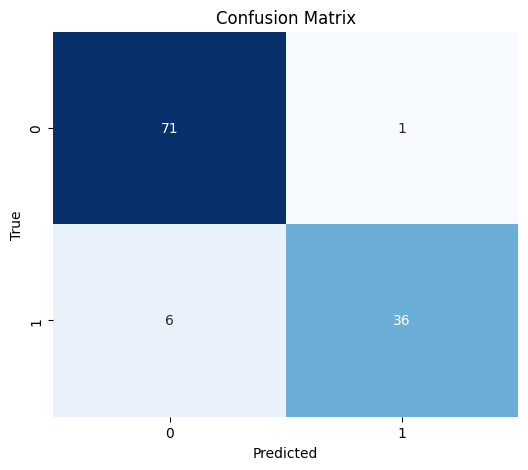


--- ROC Curve ---
Model does not support probability outputs. Skipping ROC curve.

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
      Accuracy  Precision  Recall      F1     MCC
0       0.9912     1.0000  0.9767  0.9882  0.9814
1       0.9561     0.9750  0.9070  0.9398  0.9068
2       0.9737     0.9535  0.9762  0.9647  0.9439
3       0.9825     1.0000  0.9524  0.9756  0.9626
4       0.9292     0.9474  0.8571  0.9000  0.8480
Mean    0.9665     0.9752  0.9339  0.9537  0.9285
Std     0.0220     0.0223  0.0460  0.0312  0.0472

--- Performance Analysis Complete ---
Accuracy: 0.967
Precision: 0.975
Recall: 0.934
Fbeta Score: 0.954
Mcc: 0.929


In [ ]:
   # --- Main execution flow ---

if __name__ == "__main__":

    # --- Configuration ---
    FILE_PATH = 'breast_cancer_wisconsin_diagnostic.csv' # Replace with your dataset path
    TARGET_COLUMN = 'Diagnosis' # Replace with your target column name
    MODEL_TYPE = 'Stacked1' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'
    param_grid = None
    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test,param_grid)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','F1'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','MCC'],3))

Dataset loaded successfully from breast_cancer_wisconsin_diagnostic.csv. Shape: (569, 31)
Target column 'Diagnosis' converted to numerical using LabelEncoder.

--- Starting EDA ---
Numerical features: ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
Categorical features: []

--- Handling Missing Values ---
Missing value imputation complete.

--- Performing Categorical Encoding ---
No categorical features found for encoding.

--- Standardizing Numerical Features ---
Numerical features standardized using StandardScaler.

--- EDA Complete ---

--- Splitting Dataset ---
Diagnosis
0    357
1    212
Name: count,

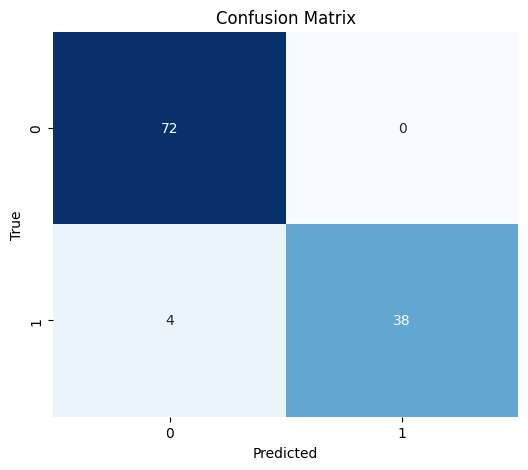


--- ROC Curve ---
Model does not support probability outputs. Skipping ROC curve.

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
      Accuracy  Precision  Recall      F1     MCC
0       0.9825     1.0000  0.9535  0.9762  0.9630
1       0.9649     0.9756  0.9302  0.9524  0.9253
2       0.9649     0.9524  0.9524  0.9524  0.9246
3       0.9825     1.0000  0.9524  0.9756  0.9626
4       0.9204     0.9231  0.8571  0.8889  0.8283
Mean    0.9630     0.9702  0.9291  0.9491  0.9208
Std     0.0227     0.0295  0.0370  0.0319  0.0492

--- Performance Analysis Complete ---
Accuracy: 0.963
Precision: 0.97
Recall: 0.929
Fbeta Score: 0.949
Mcc: 0.921


In [ ]:
   # --- Main execution flow ---

if __name__ == "__main__":

    # --- Configuration ---
    FILE_PATH = 'breast_cancer_wisconsin_diagnostic.csv' # Replace with your dataset path
    TARGET_COLUMN = 'Diagnosis' # Replace with your target column name
    MODEL_TYPE = 'Stacked2' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'
    param_grid = None
    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test,param_grid)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','F1'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','MCC'],3))

Dataset loaded successfully from breast_cancer_wisconsin_diagnostic.csv. Shape: (569, 31)
Target column 'Diagnosis' converted to numerical using LabelEncoder.

--- Starting EDA ---
Numerical features: ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
Categorical features: []

--- Handling Missing Values ---
Missing value imputation complete.

--- Performing Categorical Encoding ---
No categorical features found for encoding.

--- Standardizing Numerical Features ---
Numerical features standardized using StandardScaler.

--- EDA Complete ---

--- Splitting Dataset ---
Diagnosis
0    357
1    212
Name: count,

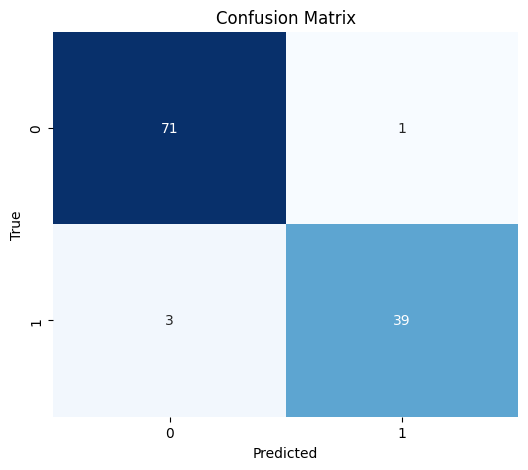


--- ROC Curve ---
Model does not support probability outputs. Skipping ROC curve.

--- Cross-Validation (5-Fold) ---

--- Cross-Validation Results (5 Folds) ---
      Accuracy  Precision  Recall      F1     MCC
0       0.9825     1.0000  0.9535  0.9762  0.9630
1       0.9649     0.9535  0.9535  0.9535  0.9253
2       0.9825     0.9762  0.9762  0.9762  0.9623
3       0.9649     0.9750  0.9286  0.9512  0.9245
4       0.9735     0.9333  1.0000  0.9655  0.9455
Mean    0.9736     0.9676  0.9623  0.9645  0.9441
Std     0.0078     0.0226  0.0241  0.0107  0.0169

--- Performance Analysis Complete ---
Accuracy: 0.974
Precision: 0.968
Recall: 0.962
Fbeta Score: 0.965
Mcc: 0.944


In [ ]:
   # --- Main execution flow ---

if __name__ == "__main__":

    # --- Configuration ---
    FILE_PATH = 'breast_cancer_wisconsin_diagnostic.csv' # Replace with your dataset path
    TARGET_COLUMN = 'Diagnosis' # Replace with your target column name
    MODEL_TYPE = 'Stacked3' # Choose from 'LogisticRegression', 'RandomForestClassifier', 'SVC'
    param_grid = None
    # Create a dummy dataset for demonstration if the file doesn't exist
    try:
        pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"'{FILE_PATH}' not found. Creating a dummy dataset for demonstration.")
        data = {
            'feature1': np.random.rand(100),
            'feature2': np.random.randint(0, 10, 100),
            'feature3': np.random.choice(['A', 'B', 'C'], 100),
            'feature4': np.random.rand(100) * 100,
            'feature5': np.random.choice([0, 1], 100), # Missing values
            'feature6': np.random.choice(['X', 'Y', 'Z'], 100), # Missing values
            'target_variable': np.random.randint(0, 2, 100)
        }
        # Introduce some missing values and outliers for demonstration
        data['feature1'][10:15] = np.nan
        data['feature5'][20:25] = np.nan
        data['feature6'][30:35] = np.nan
        data['feature4'][5] = 1000 # Outlier
        data['feature4'][90] = -500 # Outlier

        dummy_df = pd.DataFrame(data)
        dummy_df.to_csv(FILE_PATH, index=False)
        print(f"Dummy dataset '{FILE_PATH}' created.")


   # 1. Load the dataset
    df = load_dataset(FILE_PATH)

    if df is not None:
        # 2. Perform EDA
        # Ensure the target column is not affected by EDA transformations if it's categorical
        if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() > 2 :
            print("Warning: Target column is categorical or has more than 2 unique values. Ensure it's suitable for classification or adjust encoding.")
            # For this template, we assume a binary classification target.
            # If your target is multi-class or regression, adjustments will be needed.
            # For simplicity, we'll convert to numerical if it's a binary object type
            if df[TARGET_COLUMN].dtype == 'object' and df[TARGET_COLUMN].nunique() == 2:
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
                print(f"Target column '{TARGET_COLUMN}' converted to numerical using LabelEncoder.")

        processed_df, processed_target_column = perform_eda(df, TARGET_COLUMN)

        # 3. Splitting the dataset
        X_train, X_test, y_train, y_test = split_dataset(processed_df, processed_target_column)

        # 4. Model defining
        model = define_model(MODEL_TYPE)

        # 5. Performance Analysis
        cv_results_table = performance_analysis(model, X_train, y_train, X_test, y_test,param_grid)

        print("Accuracy:",round(cv_results_table.loc['Mean','Accuracy'],3))
        print("Precision:",round(cv_results_table.loc['Mean','Precision'],3))
        print("Recall:",round(cv_results_table.loc['Mean','Recall'],3))
        print("Fbeta Score:",round(cv_results_table.loc['Mean','F1'],3))
        print("Mcc:",round(cv_results_table.loc['Mean','MCC'],3))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_feature_importance(model, feature_names, title="Feature Importance"):
    """
    Plots feature importance for tree-based models.
    Works for DecisionTree, RandomForest, GradientBoosting, and XGBoost.
    """
    # Check if model has feature_importances_ attribute
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    else:
        raise ValueError("This model does not support feature importances directly.")

    # Sort features by importance
    indices = np.argsort(importance)[::-1]
    sorted_features = [feature_names[i] for i in indices]
    sorted_importance = importance[indices]

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_importance, y=sorted_features, palette="viridis")
    plt.title(title, fontsize=14)
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd


# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets
print(y)

df = pd.concat([X, y], axis=1)
df.to_csv('breast_cancer_wisconsin_diagnostic.csv',index=False)
# preview
print(df.head())
print(df.info())

    Diagnosis
0           M
1           M
2           M
3           M
4           M
..        ...
564         M
565         M
566         M
567         M
568         B

[569 rows x 1 columns]
   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  texture3  \
0      0.3001          0.14710     0.2419             0.07871  ...     17.33   
1      0.0869          0.07017     0.1812             0.05667  ...     23.41   
2      0.1974          0.12790     0.2069             0.05999  ...     25.53   
3      0.2414          0.10520     0.2597             0.09744